In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df = pd.read_csv('fitness_data.csv', parse_dates=['Date'])
# Examine the shape of the DataFrame
print("DataFrame Shape:", df.shape)

# Check data types and missing values
print("\nDataFrame Info:")
df.info()
print("\nMissing Values per column:")
print(df.isnull().sum())

DataFrame Shape: (1412, 6)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1412 entries, 0 to 1411
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1412 non-null   datetime64[ns]
 1   Time      1412 non-null   object        
 2   Steps     1412 non-null   float64       
 3   Distance  1412 non-null   float64       
 4   Energy    1412 non-null   float64       
 5   Speed     1412 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 66.3+ KB

Missing Values per column:
Date        0
Time        0
Steps       0
Distance    0
Energy      0
Speed       0
dtype: int64


In [ ]:
df['Time'] = df['Time'].str.strip()


df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time


print("\nDescriptive Statistics for Key Variables:")
key_variables = ['Steps', 'Distance', 'Energy', 'Speed']
print(df[key_variables].describe())


Descriptive Statistics for Key Variables:
             Steps     Distance        Energy        Speed
count  1412.000000  1412.000000   1412.000000  1412.000000
mean    120.076487     0.068727   2401.897868     2.741370
std     173.881897     0.099386   3477.745410     1.302993
min       0.000000     0.000000      0.011963     0.511035
25%      14.000000     0.007423    272.880317     1.599697
50%      34.000000     0.020665    685.212173     2.709679
75%     166.250000     0.096437   3327.710405     3.887836
max    1103.000000     0.714210  22065.907901     4.997037



Correlation Matrix for Numerical Variables (excluding Time):


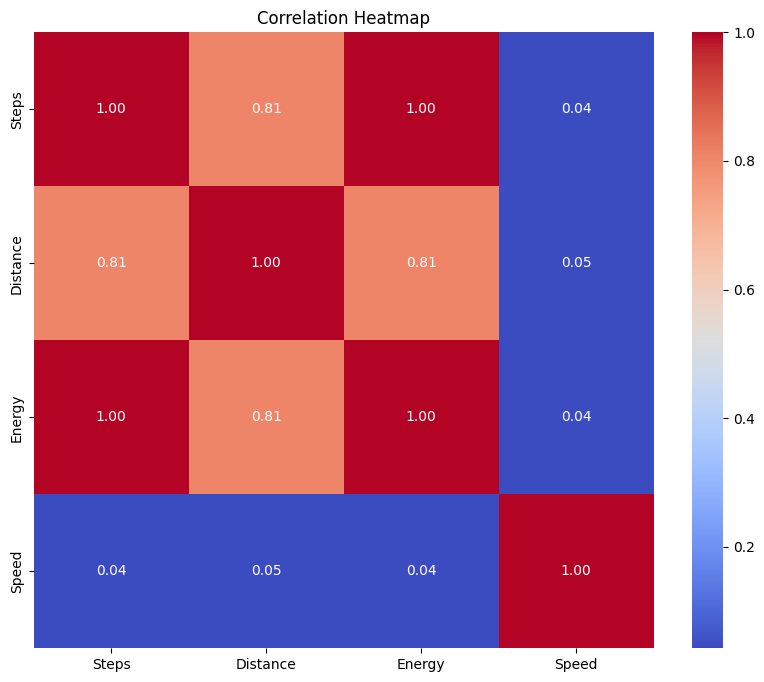

In [ ]:
print("\nCorrelation Matrix for Numerical Variables (excluding Time):")
numerical_cols = df.select_dtypes(include=['number']).columns
plt.figure(figsize=(10, 8))
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
df['Datetime'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Time'].astype(str))

df.drop_duplicates(inplace=True)


Date        datetime64[ns]
Time                object
Steps              float64
Distance           float64
Energy             float64
Speed              float64
Datetime    datetime64[ns]
dtype: object


In [ ]:
df['Avg Steps per Day'] = df.groupby('Date')['Steps'].transform('mean')


df['Day of Week'] = df['Datetime'].dt.day_name()
df['Hour of Day'] = df['Datetime'].dt.hour

df['Rolling Avg Steps (7 days)'] = df['Steps'].rolling(window=7, min_periods=1).mean().fillna(method='bfill')


def categorize_activity(steps):
    if steps < 2000:
        return 'Low'
    elif steps < 7000:
        return 'Medium'
    else:
        return 'High'

df['Activity Level'] = df['Steps'].apply(categorize_activity)


df['Active'] = (df['Steps'] > 5000).astype(int)

<ipython-input-6-39c0e862fa3c>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Rolling Avg Steps (7 days)'] = df['Steps'].rolling(window=7, min_periods=1).mean().fillna(method='bfill')


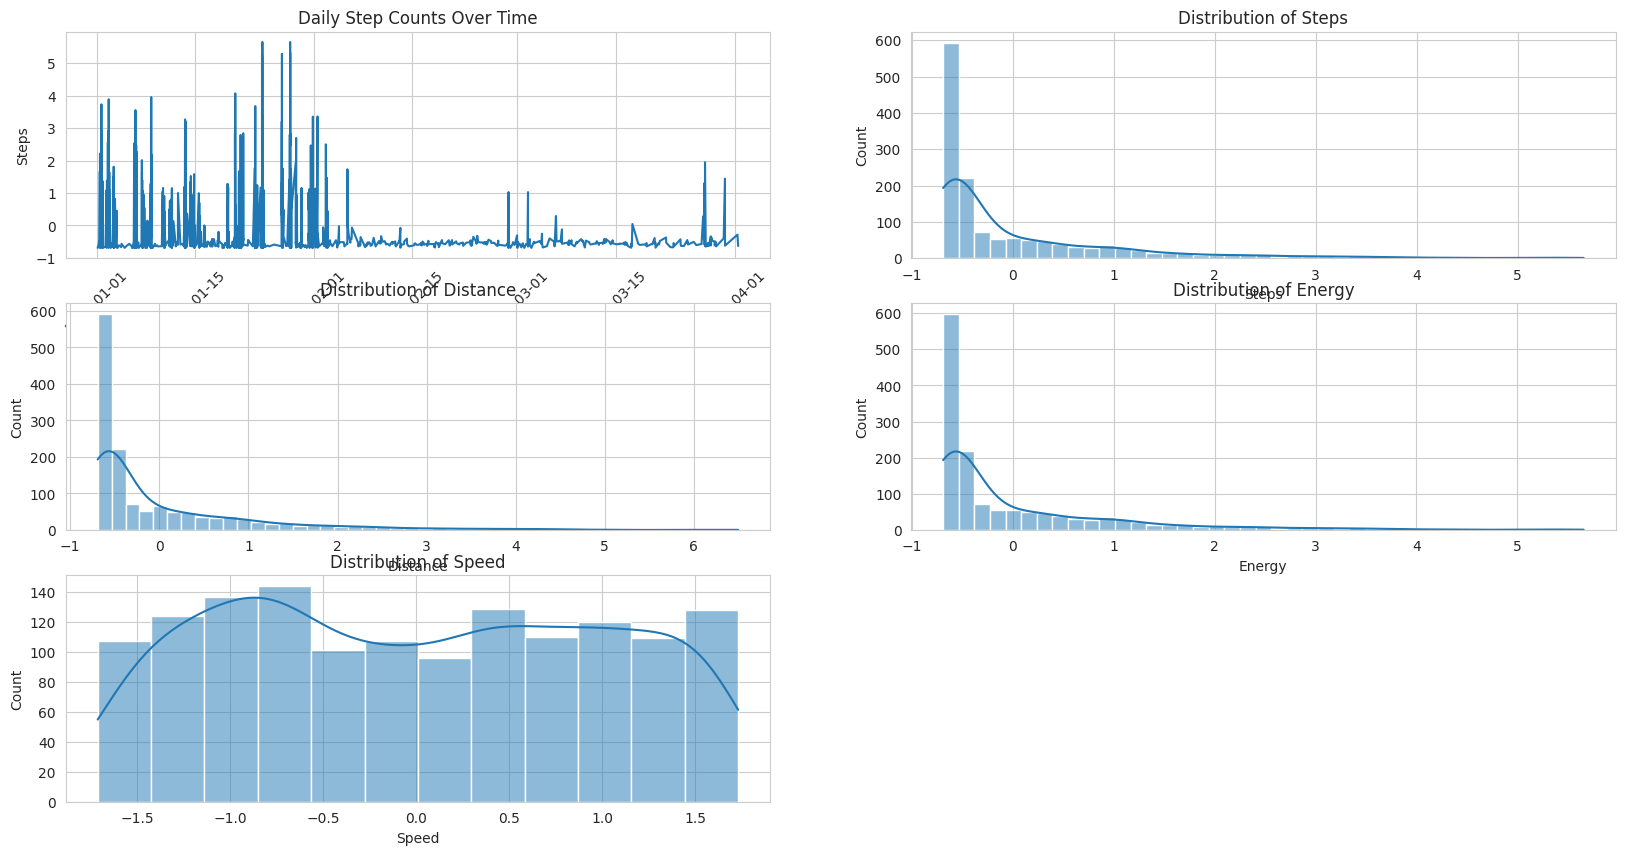

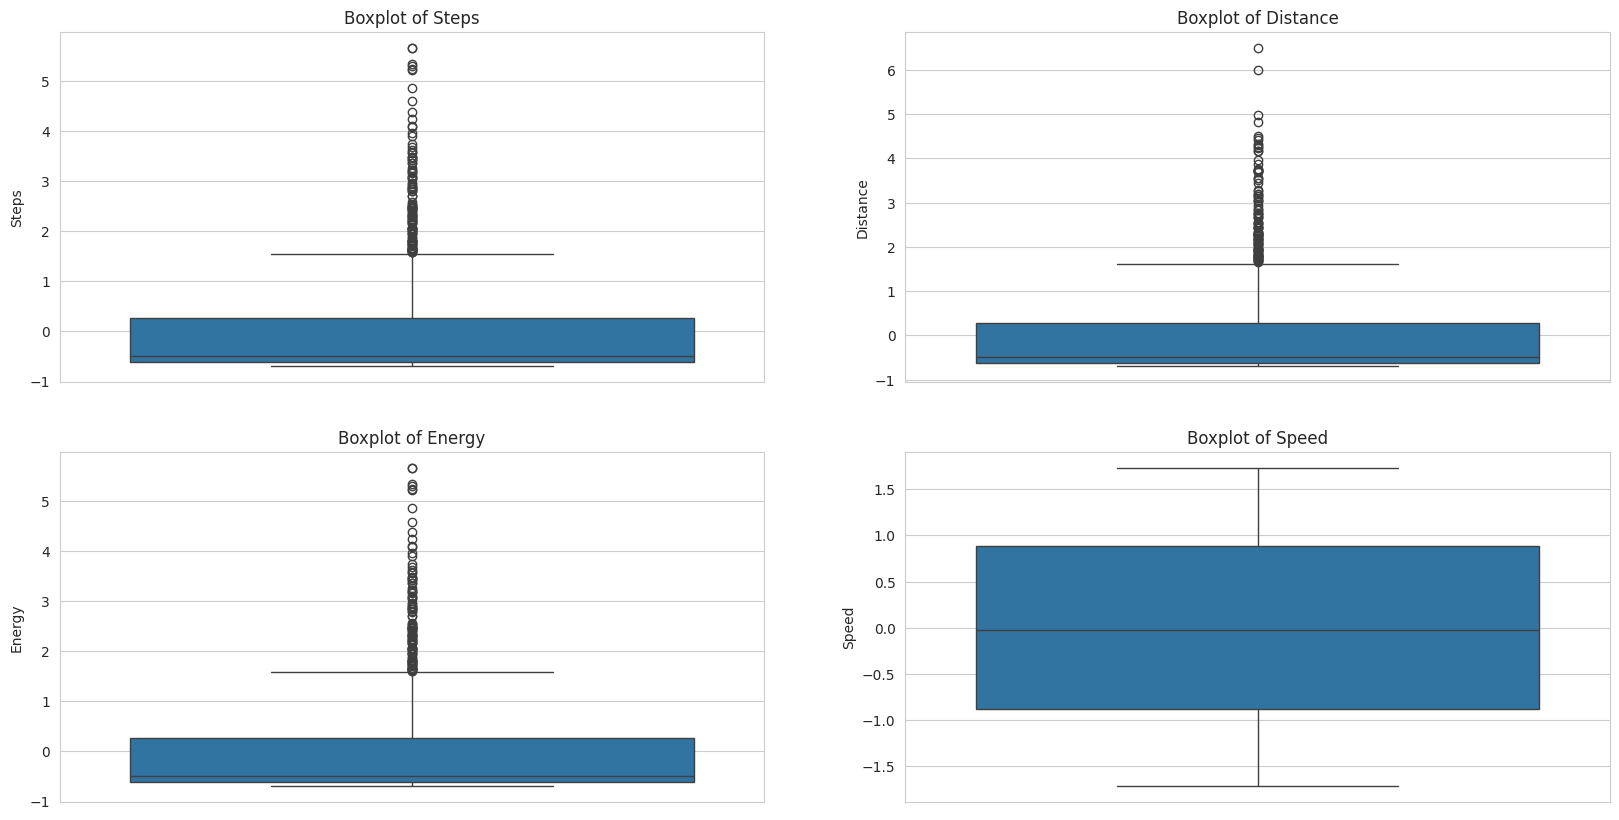

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))


plt.subplot(3, 2, 1)
plt.plot(df['Datetime'], df['Steps'])
plt.title('Daily Step Counts Over Time')
plt.xlabel('Datetime')
plt.ylabel('Steps')
plt.xticks(rotation=45)


variables = ['Steps', 'Distance', 'Energy', 'Speed']
for i, var in enumerate(variables):
    plt.subplot(3, 2, i + 2)
    sns.histplot(df[var], kde=True)
    plt.title(f'Distribution of {var}')

plt.figure(figsize=(20, 10))

for i, var in enumerate(variables):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=df[var])
    plt.title(f'Boxplot of {var}')

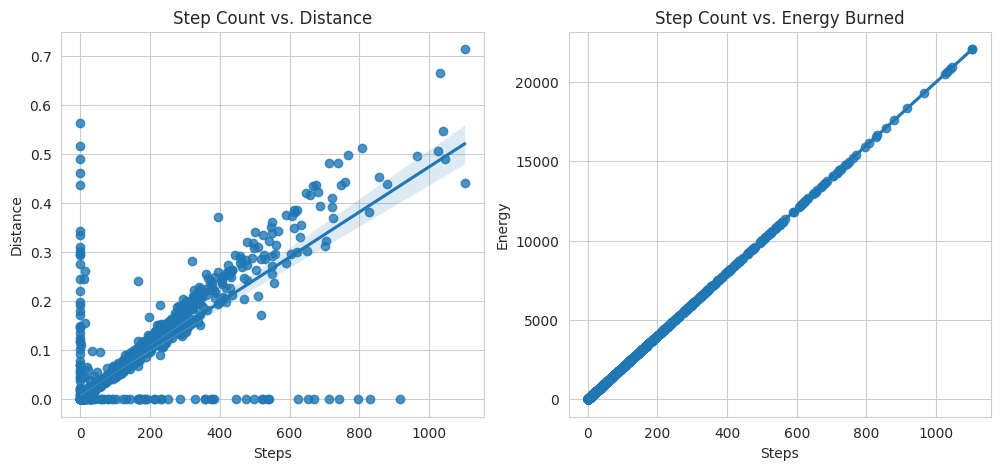

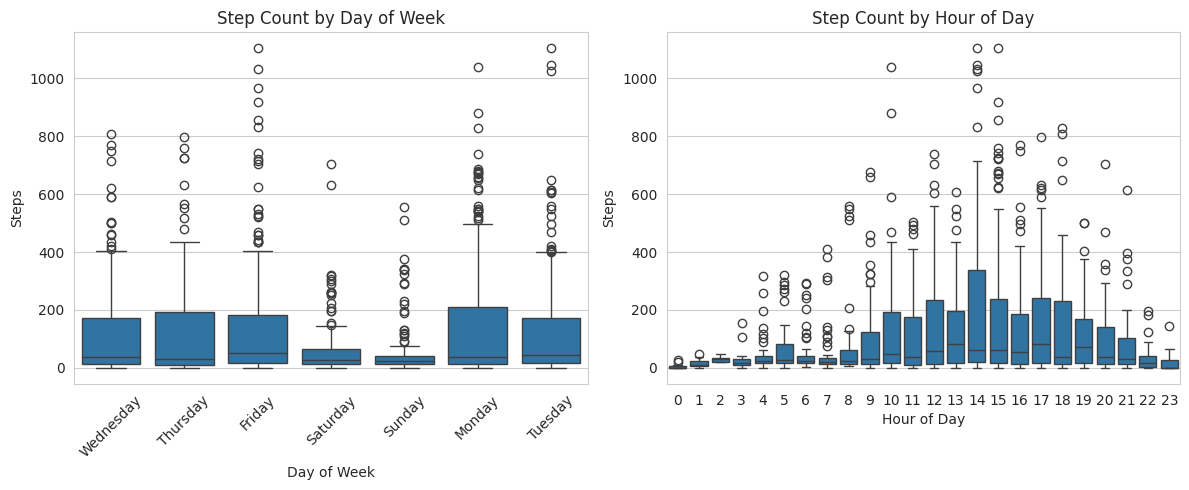

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.regplot(x='Steps', y='Distance', data=df)
plt.title('Step Count vs. Distance')

plt.subplot(1, 2, 2)
sns.regplot(x='Steps', y='Energy', data=df)
plt.title('Step Count vs. Energy Burned')


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='Day of Week', y='Steps', data=df)
plt.title('Step Count by Day of Week')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='Hour of Day', y='Steps', data=df)
plt.title('Step Count by Hour of Day')


plt.tight_layout()
plt.show()

In [ ]:
for col in ['Steps', 'Distance', 'Energy']:
    for lag in range(1, 4):
        df[f'{col}_lag_{lag}'] = df[col].shift(lag).ffill()

for window in [3, 7]:
    df[f'Step Count_rolling_mean_{window}'] = df['Steps'].rolling(window=window, min_periods=1).mean().bfill()
    df[f'Step Count_rolling_std_{window}'] = df['Steps'].rolling(window=window, min_periods=1).std().bfill()

df['Hour_sin'] = np.sin(2 * np.pi * df['Hour of Day'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour of Day'] / 24)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['Datetime'].dt.dayofweek / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['Datetime'].dt.dayofweek / 7)

In [ ]:
numerical_cols = df.select_dtypes(include=['number']).columns

cols_to_scale = [col for col in numerical_cols if col not in ['Active']]

scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
display(df.head())

,Date,Time,Steps,Distance,Energy,Speed,Datetime,Avg Steps per Day,Day of Week,Hour of Day,...,Energy_lag_2,Energy_lag_3,Step Count_rolling_mean_3,Step Count_rolling_std_3,Step Count_rolling_mean_7,Step Count_rolling_std_7,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos
0,2020-01-01,03:41:43,-0.690808,-0.691763,-0.689690,-0.946545,2020-01-01 03:41:43,1.098945,Wednesday,-1.916565,...,NaN,NaN,-0.921529,-0.735094,-1.133571,-0.997840,1.172451,1.835771,1.380053,-0.261895
1,2020-01-01,07:31:32,-0.558488,-0.547023,-0.555777,-1.145446,2020-01-01 07:31:32,1.098945,Wednesday,-1.130168,...,NaN,NaN,-0.833258,-0.735094,-1.024947,-0.997840,1.529476,0.158320,1.380053,-0.261895
2,2020-01-01,09:34:14,-0.449179,-0.480793,-0.452454,-1.018431,2020-01-01 09:34:14,1.098945,Wednesday,-0.736969,...,-0.689968,NaN,-0.755222,-0.689816,-0.928917,-0.948676,1.172451,-0.620188,1.380053,-0.261895
3,2020-01-01,11:00:16,1.627678,1.372946,1.628638,1.655204,2020-01-01 11:00:16,1.098945,Wednesday,-0.343770,...,-0.556127,-0.690260,0.275883,1.143680,-0.028436,0.808330,0.554066,-1.069660,1.380053,-0.261895
4,2020-01-01,11:04:29,1.662196,1.385628,1.662138,1.273492,2020-01-01 11:04:29,1.098945,Wednesday,-0.343770,...,-0.452859,-0.556448,1.263492,1.106246,0.523187,1.010470,0.554066,-1.069660,1.380053,-0.261895


In [ ]:
df = df.sort_values(by='Datetime')

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total_rows = len(df)
train_index = int(total_rows * train_ratio)
val_index = int(total_rows * (train_ratio + val_ratio))

df_train = df[:train_index]
df_val = df[train_index:val_index]
df_test = df[val_index:]

print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_val: {df_val.shape}")
print(f"Shape of df_test: {df_test.shape}")

Shape of df_train: (988, 30)
Shape of df_val: (212, 30)
Shape of df_test: (212, 30)


In [ ]:
# Prepare training features (X_train) and target variable (y_train)
features = ['Distance', 'Energy Burned', 'Flights Climbed', 'Walking Double Support Percentage',
            'Walking Speed', 'Avg Steps per Day', 'Hour of Day', 'Step Count_lag_1',
            'Step Count_lag_2', 'Step Count_lag_3', 'Distance_lag_1', 'Distance_lag_2',
            'Distance_lag_3', 'Energy Burned_lag_1', 'Energy Burned_lag_2', 'Energy Burned_lag_3',
            'Step Count_rolling_mean_3', 'Step Count_rolling_std_3', 'Step Count_rolling_mean_7',
            'Step Count_rolling_std_7', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']

# Check if all features exist in df_train
missing_features = set(features) - set(df_train.columns)
if missing_features:
    print(f"Warning: The following features are not in df_train and will be excluded: {missing_features}")
    features = list(set(features) - missing_features)

X_train = df_train[features]
y_train = df_train['Steps']

In [ ]:
# Instantiate and train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
X_val = df_val[features]
y_val = df_val['Steps']

y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.1029288911096441
Root Mean Squared Error (RMSE): 0.35762909088476863


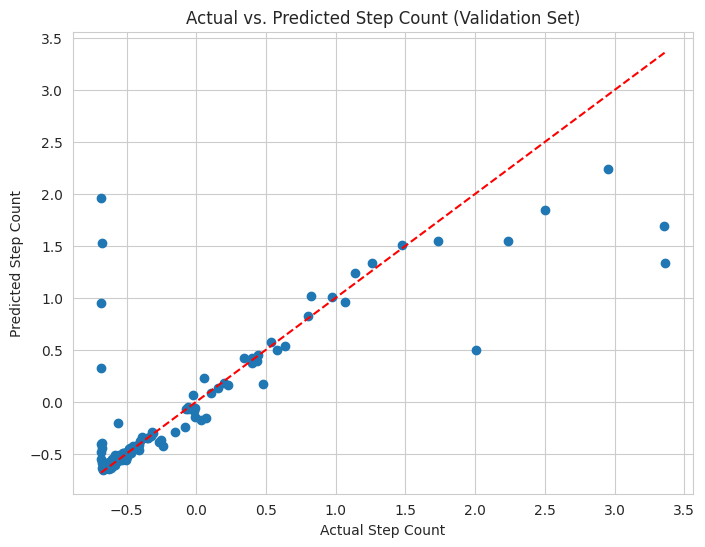

In [ ]:
# Visualize predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred)
plt.xlabel("Actual Step Count")
plt.ylabel("Predicted Step Count")
plt.title("Actual vs. Predicted Step Count (Validation Set)")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--') # Add a diagonal line
plt.show()